In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [35]:
df = pd.read_spss('data/CASPIANI.sav',convert_categoricals=True)  
df_iii = pd.read_spss('data/CASPIAN III.sav',convert_categoricals=True) 
df_iv = pd.read_spss('data/caspian4_.sav',convert_categoricals=True)
df_v = pd.read_spss('data/last-caspian-v.sav',convert_categoricals=True) 

In [36]:
def rename_features(df,caspian_number):
    # Rename the features in the dataframe
    if caspian_number==5:
        result_df = df.rename(columns={'weight_1':'weight','height_2':'height','universi':'university'})
    elif caspian_number==4:
        result_df = df.rename(columns={'sex': 'sex1','sex2': 'sex','weight_1':'weight','height_2':'height', 'University': 'university'})
    elif caspian_number==3:
        result_df=df.rename(columns={'weighte':'weight','heighte':'height', 'province':'university'})
    elif caspian_number==1:
        result_df=df.rename(columns={'univer':'university'})
        result_df.columns = result_df.columns.str.lower()
    return result_df

In [37]:
df_v = rename_features(df_v,5)
df_iv=rename_features(df_iv,4)
df_iii = rename_features(df_iii,3)
df = rename_features(df,1)

In [38]:
df['sex'] = df['sex'].apply(lambda x: 'Girl' if x == 'Female' else 'Boy' if x == 'Male' else x)
df_iii['sex'] = df_iii['sex'].apply(lambda x: 'Girl' if x == 'female' else 'Boy' if x == 'male' else x)
df_iv['sex'] = df_iv['sex'].apply(lambda x: 'Girl' if x == 'girl' else 'Boy' if x == 'boy' else x)

In [39]:
df_dict = {'caspian_I': df, 'caspian_III': df_iii, 'caspian_IV': df_iv, 'caspian_V': df_v}

shape of each dataset


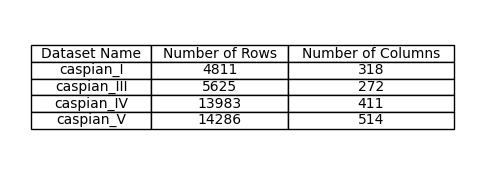

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample function that returns the shape of the DataFrame
def dataframe_info(df):
    return df.shape

# Collect data into a list for the table
table_data = []
for name, df in df_dict.items():
    shape = dataframe_info(df)
    table_data.append([name, shape[0], shape[1]])  # [Dataset Name, Rows, Columns]

# Convert list to DataFrame
table_df = pd.DataFrame(table_data, columns=['Dataset Name', 'Number of Rows', 'Number of Columns'])

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figsize for readability
ax.axis('off')  # Hide axes

# Render table
table = ax.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_df.columns))))

# Save the table as an image
plt.savefig("table_image.png", bbox_inches='tight', dpi=300)
plt.show()



number of boys and girls in each data set

first we change all value of sex for all dataframes to have a same value for sex column:

now we draw charts for compare distribution of Girls and Boys in each dataframe:


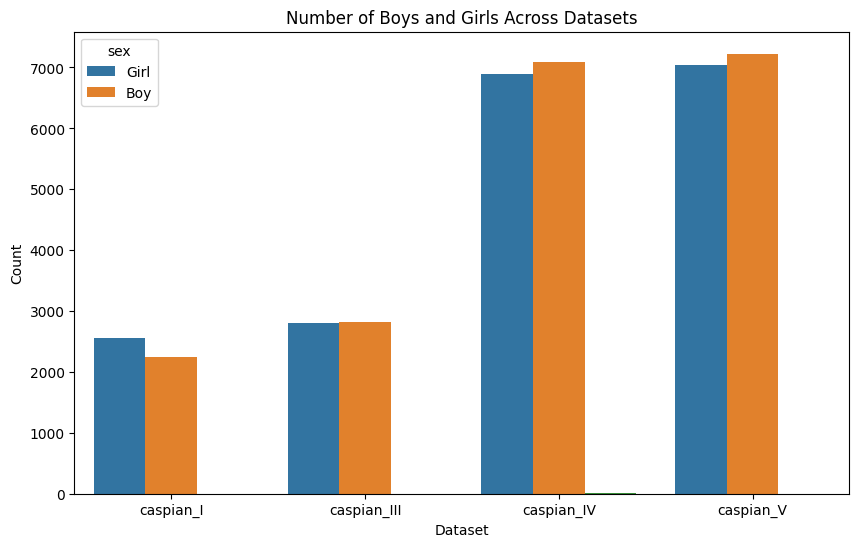

In [41]:
# Function to combine and plot counts
def plot_gender_counts(dataframes_dict, filename="gender_counts_plot.png"):
    # List to store counts for each dataset
    combined_data = []

    # Iterate over each dataframe and compute counts
    for name, df in dataframes_dict.items():
        counts = df['sex'].value_counts().reset_index()
        counts.columns = ['sex', 'count']
        counts['dataset'] = name  # Use the name from the dictionary as dataset label
        combined_data.append(counts)
    
    # Concatenate all counts into a single DataFrame
    combined_df = pd.concat(combined_data, ignore_index=True)

    # Plot with seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=combined_df, x='dataset', y='count', hue='sex')
    plt.title('Number of Boys and Girls Across Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Count')
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()


# Usage
plot_gender_counts(df_dict)


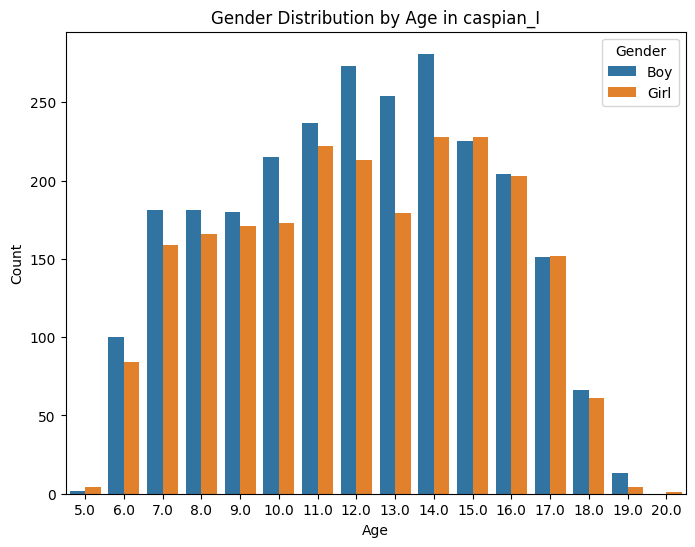

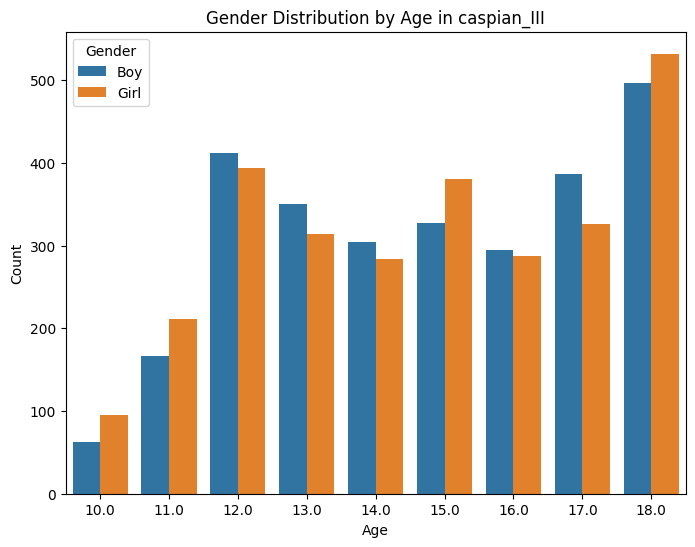

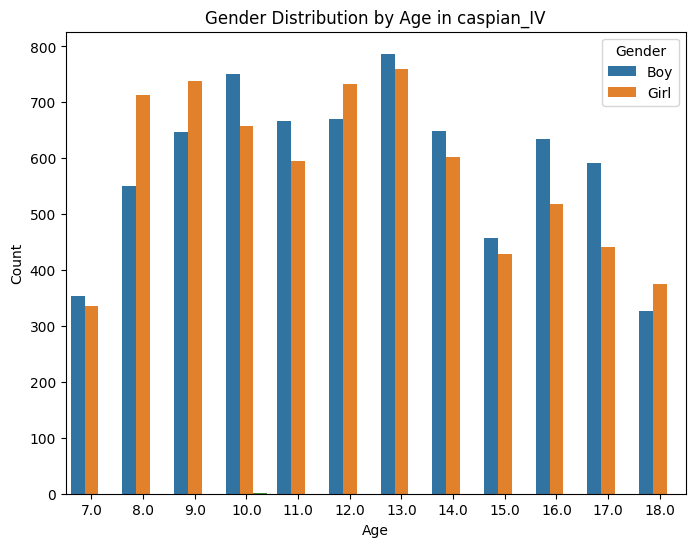

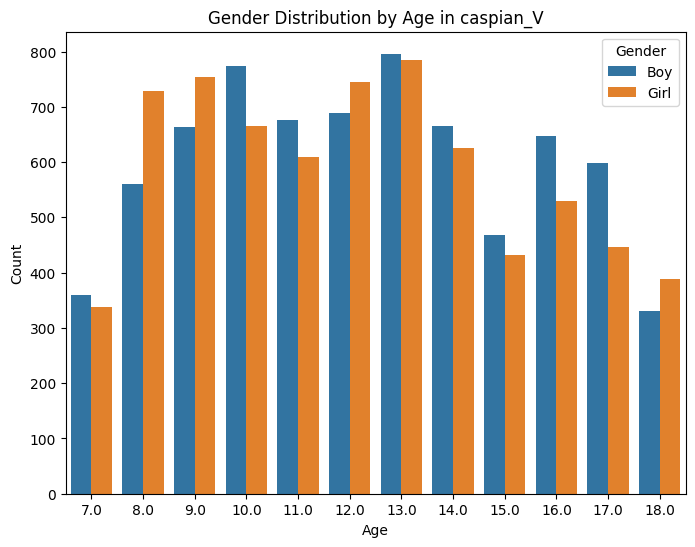

In [42]:
# Function to plot counts by age for each dataset
def plot_gender_age_distribution(dataframes_dict):
    for name, df in dataframes_dict.items():
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x='age', hue='sex')
        plt.title(f'Gender Distribution by Age in {name}')
        plt.xlabel('Age')
        plt.ylabel('Count')
        plt.legend(title='Gender', labels=['Boy', 'Girl'])
        plt.savefig(f"{name}_gender_age_distribution.png", bbox_inches='tight', dpi=300)
        plt.show()

# Usage
plot_gender_age_distribution(df_dict)


add a preprocessing step for additional works

In [61]:
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()

        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]
        # please change the type of heught_1 and weight_1 in caspian4 to numeric if you can't do it directly uncomment two line below
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)
        
        # Remove null tuples
        records_with_nulls = df[
            df[["weight", "height", "sex", "age"]].isna().any(axis=1)
        ]
        df = df.dropna(subset=["height", "weight", "sex"])
        print(
            f"Number of records with NaN value in weight or height in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs


# Usage
processed_dfs = preprocess(df_dict)

Number of records with NaN value in weight or height in caspian_I: 11
Number of records with NaN value in weight or height in caspian_III: 0
Number of records with NaN value in weight or height in caspian_IV: 143
Number of records with NaN value in weight or height in caspian_V: 128


check if our bmi is equal to dataset bmi or not
bmi1 is our bmi and bmi is dataset bmi:
result is:
Only the Caspian IV dataset shows a difference between our BMI (bmi1) and the dataset BMI (bmi); all other datasets have matching BMI values.

In [57]:
import numpy as np

# Identify rows where 'bmi' and 'bmi1' are not close within a small tolerance
differences = processed_dfs['caspian_V'][~np.isclose(processed_dfs['caspian_V']['bmi'], processed_dfs['caspian_V']['bmi1'], atol=1e-6)]

# Print only rows with significant differences
if not differences.empty:
    print(differences[['weight','height','bmi', 'bmi1']])
else:
    print("No significant differences found.")

No significant differences found.


In [62]:
def growth_chart(processed_dfs, feature, percentiles, sex, frec_rate):
    for name, preprocess_df in processed_dfs.items():
        def calculate_percentiles(group):
            return np.percentile(group[feature], percentiles)

        # Calculate percentiles
        percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
            lambda g: pd.Series(calculate_percentiles(g), index=[f'Percentile_{p}' for p in percentiles])
        )
        
        percentile_results.reset_index(inplace=True)
        
        if percentile_results.empty:
            print(f"No percentile results for {name} with feature {feature}")
            continue
        
        # Filter based on sex
        if sex == 'Boy':
            percentile_results_gender = percentile_results[percentile_results['sex'] == 'Boy']
            gender = "Boy"
        else:
            percentile_results_gender = percentile_results[percentile_results['sex'] == 'Girl']
            gender = "Girl"

        if percentile_results_gender.empty:
            print(f"No data for {gender} in {name} with feature {feature}")
            continue

        ages = percentile_results_gender['age']
        
        plt.figure(figsize=(12, 8))

        for i, percentile in enumerate(percentiles):
            percentile_data = percentile_results_gender[f'Percentile_{percentile}']

            # Ensure there’s data to plot
            if percentile_data.empty:
                print(f"No data for {percentile}th percentile for {gender} in {name}")
                continue
            
            # Fit LOESS model
            smoothed = sm.nonparametric.lowess(percentile_data, ages, frac=frec_rate)
            
            if smoothed.size == 0:
                print(f"No smoothed data for {percentile}th percentile for {gender} in {name}")
                continue
            
            # Plot the smoothed curve
            plt.plot(smoothed[:, 0], smoothed[:, 1], label=f'{percentile}th Percentile', color=plt.cm.plasma(i / len(percentiles)))
        
        plt.xlabel('Age')
        plt.ylabel(feature)
        plt.title(f'Growth Chart for {gender}')
        plt.legend()
        plt.grid(True)
        
        # Check that saving folder exists
        saving_folder = f'charts/{name}-smooth'
        if not os.path.exists(saving_folder):
            os.makedirs(saving_folder)
        
        # Save figure
        plt.savefig(f'{saving_folder}/{gender}-{feature}-age_smooth-{name}.png')
        plt.close()

        print(f"Chart saved for {gender} in {name} with feature {feature}")

In [63]:
# Define percentiles for each feature
percentile_settings = {
    'height': [3, 5, 10 , 25, 50, 75, 90, 95, 97],  # Percentiles for height
    'weight': [3, 5, 10 , 25, 50, 75, 90, 95, 97],  # Percentiles for weight
    'bmi1': [3, 5, 10 , 25, 50, 75, 85, 90, 95, 97]      # Different percentiles for BMI
}

# Define genders
genders = ['Boy', 'Girl']

# Fraction rate for LOESS smoothing
frec_rate = 0.6

# Call the growth_chart function for each combination of feature and gender
for feature, percentiles in percentile_settings.items():
    for gender in genders:
        growth_chart(processed_dfs=processed_dfs, feature=feature, percentiles=percentiles, sex=gender, frec_rate=frec_rate)


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_I with feature height


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_III with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_IV with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_V with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_I with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_III with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_IV with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_V with feature height


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_I with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_III with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_IV with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_V with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_I with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_III with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_IV with feature weight


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_V with feature weight


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_I with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_III with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_IV with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Boy in caspian_V with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_I with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_III with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(
/tmp/ipykernel_42822/708921124.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_IV with feature bmi1


/tmp/ipykernel_42822/708921124.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentile_results = preprocess_df.groupby(['age', 'sex'], group_keys=False).apply(


Chart saved for Girl in caspian_V with feature bmi1
